In [57]:
from read_data import *
data_dict = process_data()

In [353]:
# Visualizing the dataset: Observation -> V2
data_dict["V2_00001"]["dat"]

,CH1_Moment,CH2_Kraft,CH3_SyncSig,CH4_akustik,CH5_a1_WSAS,CH6_a2_WSAF,CH7_a3_BOZA,time
0,-25.056,275.904,10.9664,-0.0012,-4.832,-2.936,-0.16,0.00000
1,-33.048,714.668,10.9736,-0.0092,-4.952,-7.968,0.24,0.00005
2,-26.712,486.664,10.9688,-0.0192,-4.608,-13.640,2.08,0.00010
3,-11.952,-252.912,10.9672,-0.0470,-5.928,-8.600,3.00,0.00015
4,0.360,-956.084,10.9664,-0.0674,-4.384,0.344,3.76,0.00020
...,...,...,...,...,...,...,...,...
5829931,-1.008,-164.776,10.9672,-0.0590,0.064,-0.048,0.04,291.49655
5829932,3.816,-465.588,10.9616,-0.0604,0.048,-0.128,0.04,291.49660
5829933,7.632,-668.684,10.9696,-0.0542,0.112,-0.056,-0.12,291.49665
5829934,7.128,-549.892,10.9656,-0.0488,0.072,-0.128,0.00,291.49670


## Change point detection

In [359]:
import ruptures as rpt
def generate_change_points(exp, sensor):
    sensor_data = pd.DataFrame(data_dict[f"{exp}"]["dat"][f"{sensor}"])
    sensor_data.index = data_dict[f"{exp}"]["dat"]["time"]
    sensor_data.index = pd.to_datetime(sensor_data.index, unit='s')

    algo = rpt.BottomUp(model="normal",min_size=20000).fit(sensor_data.values)
    result = algo.predict(n_bkps=6)

    # Calculate the breaking points:
    breaks_rpt = []
    for i in result:
        breaks_rpt.append(sensor_data.index[i-1])
    breaks_rpt = pd.to_datetime(breaks_rpt)

    return breaks_rpt, sensor_data

In [375]:
breaks_rpt_1, ch1_moment_1 = generate_change_points("V10_0001", "CH1_Moment")
breaks_rpt_2, ch1_moment_2 = generate_change_points("D0400001", "CH1_Moment")
breaks_rpt_3, ch1_moment_3 = generate_change_points("D0600001", "CH1_Moment")
breaks_rpt_4, ch1_moment_4 = generate_change_points("D0800001", "CH1_Moment")

/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(
/Users/aymanehachcham/miniconda3/envs/tad/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (se

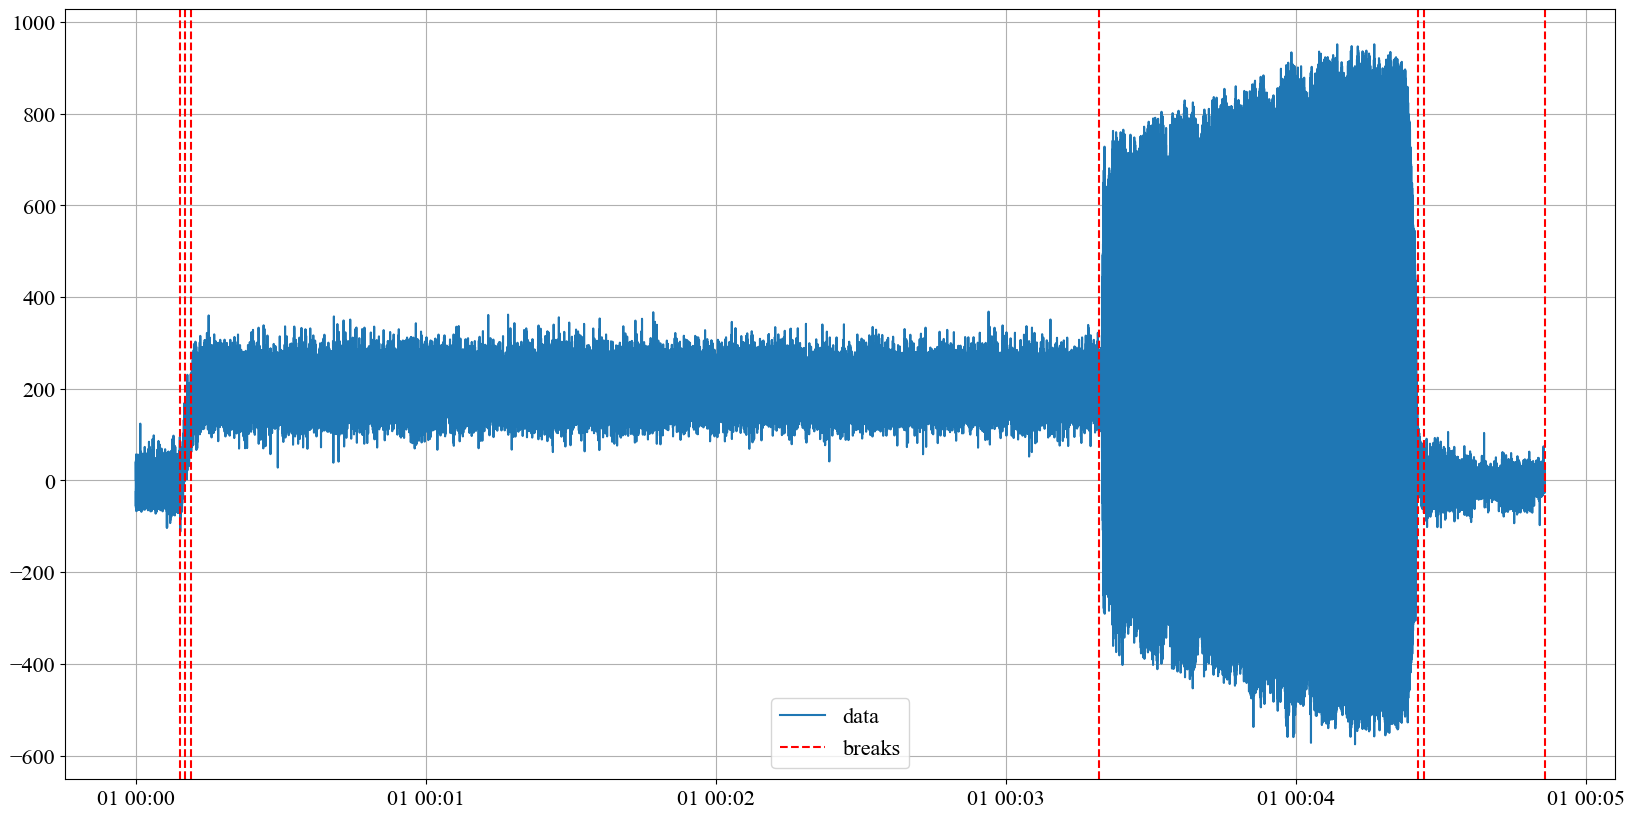

In [362]:
# plot the breaks_rpt in the ch1_moment_2 data:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(ch1_moment_2, label='data')
print_legend = True

for i in breaks_rpt_2:
    if print_legend:
        axs.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        axs.axvline(i, color='red',linestyle='dashed')

axs.grid()
axs.legend()
plt.show()

## Fourier transform

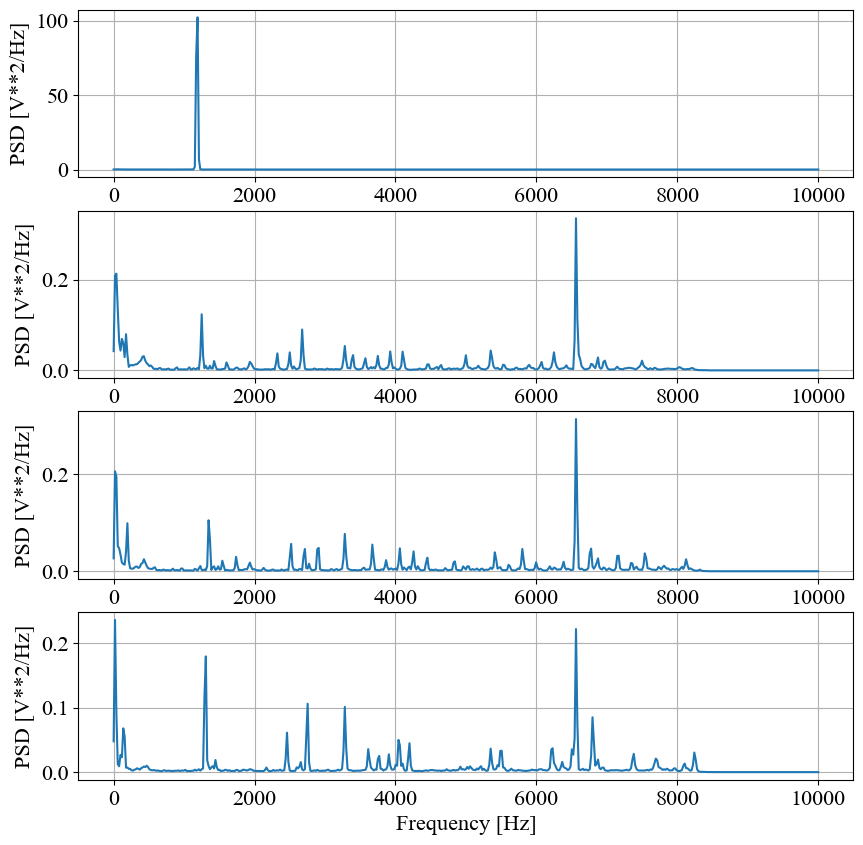

In [376]:
import scipy.signal as signal
from scipy.signal import find_peaks

def generate_points(breaking_points, sensor_data):
    # take the ch1_moment values that correspond to each break point:
    breaks_ch1_moment = []
    for i in breaking_points:
        breaks_ch1_moment.append(sensor_data.loc[i])

    # take the 10000 observations before each break point:
    before = sensor_data.loc[:breaking_points[3]][-20000:]
    after = sensor_data.loc[breaking_points[3]:][0:20000]

    data_bf = before.values.reshape(-1)
    data_af = after.values.reshape(-1)

    data_bf_af = np.concatenate((data_bf, data_af), axis=None)

    return data_bf_af

def detect_eigen_frequencies(data_1, data_2, data_3, data_4):
    # compute the power spectral density of the data_1 and data_2
    # using the welch method:
    T = 1/20000

    f_1, Pxx_den_1 = signal.welch(data_1, fs=1/T, nperseg=1024)
    peaks_1, _ = find_peaks(Pxx_den_1, height=0.0001)

    f_2, Pxx_den_2 = signal.welch(data_2, fs=1/T, nperseg=1024)
    peaks_2, _ = find_peaks(Pxx_den_2, height=0.0001)

    f_3, Pxx_den_3 = signal.welch(data_3, fs=1/T, nperseg=1024)
    peaks_3, _ = find_peaks(Pxx_den_3, height=0.0001)

    f_4, Pxx_den_4 = signal.welch(data_4, fs=1/T, nperseg=1024)
    peaks_4, _ = find_peaks(Pxx_den_4, height=0.0001)

    # Plot 4 plots of the psd and the identified peaks for the two data:
    fig, axs = plt.subplots(4, 1, figsize=(10, 10))
    axs[0].plot(f_1, Pxx_den_1)
    # axs[0].plot(f_1[peaks_1], Pxx_den_1[peaks_1], "x")
    axs[0].set_xlabel('Frequency [Hz]')
    axs[0].set_ylabel('PSD [V**2/Hz]')
    axs[0].grid()

    axs[1].plot(f_2, Pxx_den_2)
    # axs[1].plot(f_2[peaks_2], Pxx_den_2[peaks_2], "x")
    axs[1].set_xlabel('Frequency [Hz]')
    axs[1].set_ylabel('PSD [V**2/Hz]')
    axs[1].grid()

    axs[2].plot(f_3, Pxx_den_3)
    # axs[1].plot(f_2[peaks_2], Pxx_den_2[peaks_2], "x")
    axs[2].set_xlabel('Frequency [Hz]')
    axs[2].set_ylabel('PSD [V**2/Hz]')
    axs[2].grid()

    axs[3].plot(f_4, Pxx_den_4)
    # axs[1].plot(f_2[peaks_2], Pxx_den_2[peaks_2], "x")
    axs[3].set_xlabel('Frequency [Hz]')
    axs[3].set_ylabel('PSD [V**2/Hz]')
    axs[3].grid()

    plt.show()



data_1 = generate_points(breaks_rpt_1, ch1_moment_1)
data_2 = generate_points(breaks_rpt_2, ch1_moment_2)
data_3 = generate_points(breaks_rpt_3, ch1_moment_3)
data_4 = generate_points(breaks_rpt_4, ch1_moment_4)

detect_eigen_frequencies(data_1, data_2, data_3, data_4)

## Detect Eigen frequencies in the spectrum of the data:

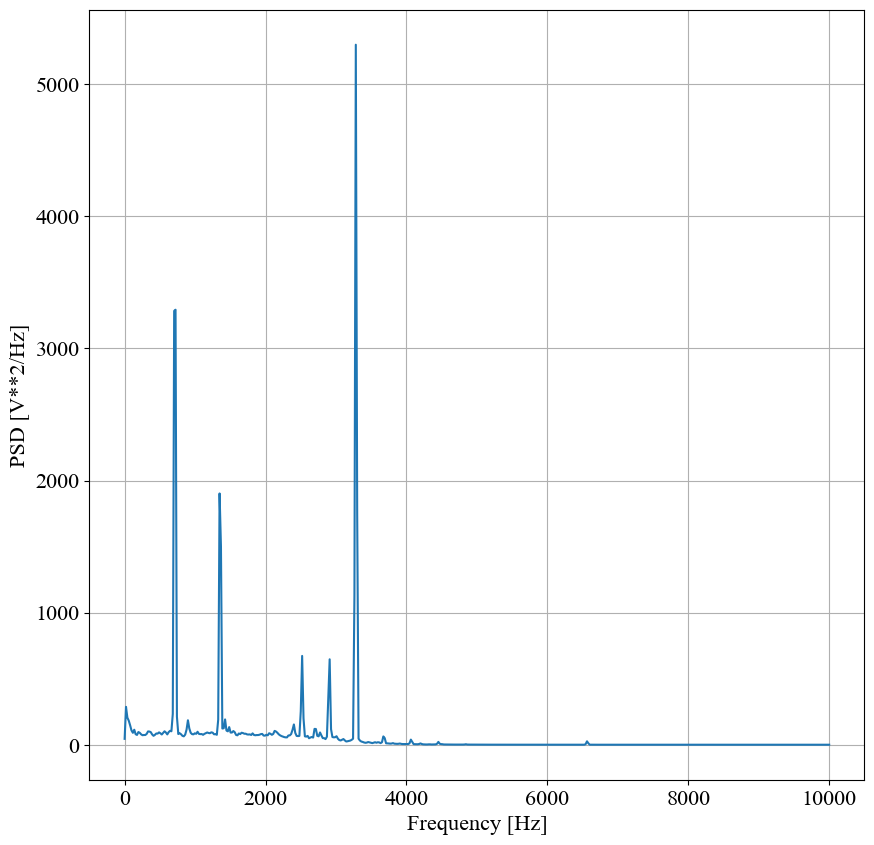

In [344]:
# compute the power spectral density of the data using the welch method:
import scipy.signal as signal

f, Pxx_den = signal.welch(data_1, fs=1/T, nperseg=1024)

# Find the peaks in the power spectral density:
from scipy.signal import find_peaks

peaks, _ = find_peaks(Pxx_den, height=0.0001)

# Plot the psd and the identified peaks:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.plot(f, Pxx_den)
# axs.plot(f[peaks], Pxx_den[peaks], "x")
axs.set_xlabel('Frequency [Hz]')
axs.set_ylabel('PSD [V**2/Hz]')
axs.grid()
plt.show()

# compute the power spectral density of the data using the welch method:
f, Pxx_den = signal.welch(data_2, fs=1/T, nperseg=1024)

# Find the peaks in the power spectral density:
from scipy.signal import find_peaks

peaks, _ = find_peaks(Pxx_den, height=0.0001)

# Plot the psd and the identified peaks:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.plot(f, Pxx_den)
# axs.plot(f[peaks], Pxx_den[peaks], "x")
axs.set_xlabel('Frequency [Hz]')
axs.set_ylabel('PSD [V**2/Hz]')
axs.grid()
plt.show()

In [345]:
# take the 3 highest Pxx_den[peaks]:
peaks = peaks[np.argsort(Pxx_den[peaks])[-10:]]
peaks = np.sort(peaks)[::-1]

f[peaks]

array([3281.25   , 2910.15625, 2519.53125, 2402.34375, 1484.375  ,
       1425.78125, 1347.65625,  898.4375 ,  722.65625,   19.53125])

In [346]:
Pxx_den[peaks]

array([5299.23372815,  646.60196171,  672.24887241,  153.52763097,
        133.45462234,  191.41760815, 1902.10445247,  184.98709738,
       3292.99807848,  286.54908972])